In [3]:
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets.fashion_mnist import load_data
import matplotlib.pyplot as plt

import time
import random
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random

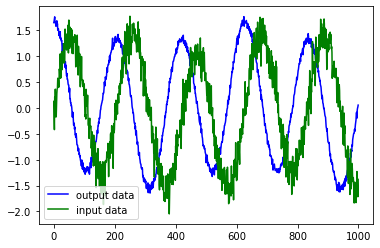

In [4]:
n_timesteps_in = 10 
n_timesteps_out = 15
n_features_in = 1
n_features_out = 1
n_for_train = 500
n_for_test = 5
time_series_length = 1000

t = np.linspace(0, 10, time_series_length)
ts_input = np.sin(t) / 3 + 2 * np.sin(t*3) + 0.3 * np.random.standard_normal(size=time_series_length)
ts_output = np.cos(t) / 2 + 3 * np.cos(t*3) + 0.1 * np.random.standard_normal(size=time_series_length)

ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)

plt.plot(ts_norm_output,'b', label = 'output data')
plt.plot(ts_norm_input, 'g', label = 'input data')
plt.legend()

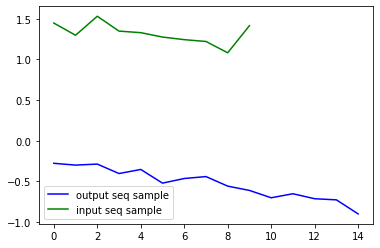

In [27]:
train_size = int(len(ts_input) * 0.8)
test_size = len(ts_input) - train_size

train_input, test_input = ts_norm_input[:train_size], ts_norm_input[train_size:]
train_output, test_output = ts_norm_output[:train_size], ts_norm_output[train_size:]

seq_len = max(n_timesteps_in, n_timesteps_out)

train_input_data, train_output_data = [], []
test_input_data, test_output_data = [], []   

for i in range(n_for_test):
    rand_ind_test = random.randint(0, len(test_input) - seq_len)
    input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
    output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
    test_input_data.append(input_seq)
    test_output_data.append(output_seq)

for i in range(n_for_train):
    rand_ind_train = random.randint(0, len(train_input) - seq_len)
    input_seq = ts_norm_input[rand_ind_train:rand_ind_train+n_timesteps_in]
    output_seq = ts_norm_output[rand_ind_train:rand_ind_train+n_timesteps_out]
    train_input_data.append(input_seq)
    train_output_data.append(output_seq)

train_input_data = np.array(train_input_data)
train_output_data = np.array(train_output_data)

test_input_data = np.array(test_input_data)
test_output_data = np.array(test_output_data)

plt.plot(train_output_data[0], 'b', label = 'output seq sample')
plt.plot(train_input_data[0], 'g', label = 'input seq sample')
plt.legend()

In [28]:
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))

n_units = 256

encoder_inputs = keras.Input(shape=(n_timesteps_in, n_features_in))
encoder = keras.layers.LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]
decoder_inputs = keras.Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  keras.layers.LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)


model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 15, 1)]      0           []                               
                                                                                                  
 lstm_6 (LSTM)                  [(None, 256),        264192      ['input_7[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [29]:
model.compile(optimizer='adam', loss='mse')
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.2, callbacks = my_callbacks, verbose=2)

Epoch 1/100
7/7 - 3s - loss: 0.9995 - val_loss: 1.0019 - 3s/epoch - 367ms/step
Epoch 2/100
7/7 - 0s - loss: 0.9759 - val_loss: 0.9499 - 228ms/epoch - 33ms/step
Epoch 3/100
7/7 - 0s - loss: 0.8563 - val_loss: 0.8492 - 216ms/epoch - 31ms/step
Epoch 4/100
7/7 - 0s - loss: 0.8310 - val_loss: 0.7639 - 221ms/epoch - 32ms/step
Epoch 5/100
7/7 - 0s - loss: 0.8190 - val_loss: 0.8449 - 225ms/epoch - 32ms/step
Epoch 6/100
7/7 - 0s - loss: 0.7930 - val_loss: 0.7407 - 217ms/epoch - 31ms/step
Epoch 7/100
7/7 - 0s - loss: 0.6648 - val_loss: 0.5614 - 215ms/epoch - 31ms/step
Epoch 8/100
7/7 - 0s - loss: 0.5916 - val_loss: 0.5521 - 215ms/epoch - 31ms/step
Epoch 9/100
7/7 - 0s - loss: 0.5479 - val_loss: 0.4999 - 221ms/epoch - 32ms/step
Epoch 10/100
7/7 - 0s - loss: 0.5137 - val_loss: 0.5101 - 220ms/epoch - 31ms/step
Epoch 11/100
7/7 - 0s - loss: 0.5286 - val_loss: 0.5932 - 214ms/epoch - 31ms/step
Epoch 12/100
7/7 - 0s - loss: 0.5196 - val_loss: 0.4612 - 216ms/epoch - 31ms/step
Epoch 13/100
7/7 - 0s - los

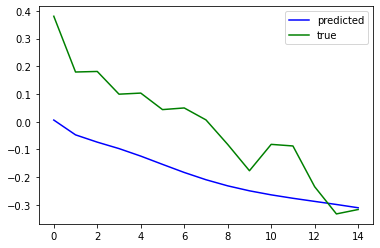

In [30]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])

plt.plot(y_pred[0], 'b', label = 'predicted')
plt.plot(test_output_data[0], 'g', label = 'true')
plt.legend()

In [171]:
np.random.seed(1337)
num_classes = 10

epochs = 8
latent_dim = 128

adam_lr = 0.002
adam_beta_1 = 0.4

batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28


In [172]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)
dataset = tf.data.Dataset.from_tensor_slices((all_digits,all_labels))
dataset = dataset.shuffle(buffer_size=512).batch(batch_size).prefetch(32)


In [173]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, 1)),
        layers.Conv2D(256, (3, 3), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.3),
        layers.Dropout(0.5),
        layers.GlobalMaxPooling2D(),
        
        layers.Conv2D(32, (1, 1), strides=(3, 3), padding="same"),
        layers.LeakyReLU(alpha=0.3),
        layers.Dropout(0.5),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1, activation='sigmoid'),
    ],
    name="discriminator",
)


generator = keras.Sequential(
    [
        keras.layers.InputLayer((128,)),
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", kernel_initializer='glorot_normal'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.3),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid", kernel_initializer='glorot_normal'),
        
    ],
    name="generator",
)

In [174]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [175]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

In [176]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
        d_optimizer=tf.keras.optimizers.Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        g_optimizer=tf.keras.optimizers.Adam(learning_rate=adam_lr, beta_1=adam_beta_1),
        loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    )

In [177]:
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/8
1094/1094 [==============================] - 3514s 3s/step - d_loss: 0.5895 - g_loss: 1.2711
Epoch 2/8
1094/1094 [==============================] - 3458s 3s/step - d_loss: 0.7883 - g_loss: 1.3133
Epoch 3/8
1094/1094 [==============================] - 3494s 3s/step - d_loss: 0.7883 - g_loss: 1.3133
Epoch 4/8
1094/1094 [==============================] - 3651s 3s/step - d_loss: 0.7883 - g_loss: 1.3133
Epoch 5/8
1094/1094 [==============================] - 3817s 3s/step - d_loss: 0.7882 - g_loss: 1.3133
Epoch 6/8
1094/1094 [==============================] - 3825s 3s/step - d_loss: 0.7883 - g_loss: 1.3133
Epoch 7/8
1094/1094 [==============================] - 3813s 3s/step - d_loss: 0.7883 - g_loss: 1.3133
Epoch 8/8
1094/1094 [==============================] - 3818s 3s/step - d_loss: 0.7883 - g_loss: 1.3133


In [179]:
Image.open("generated_img_2_4.png")

In [185]:
Image.open("generated_img_1_7.png")